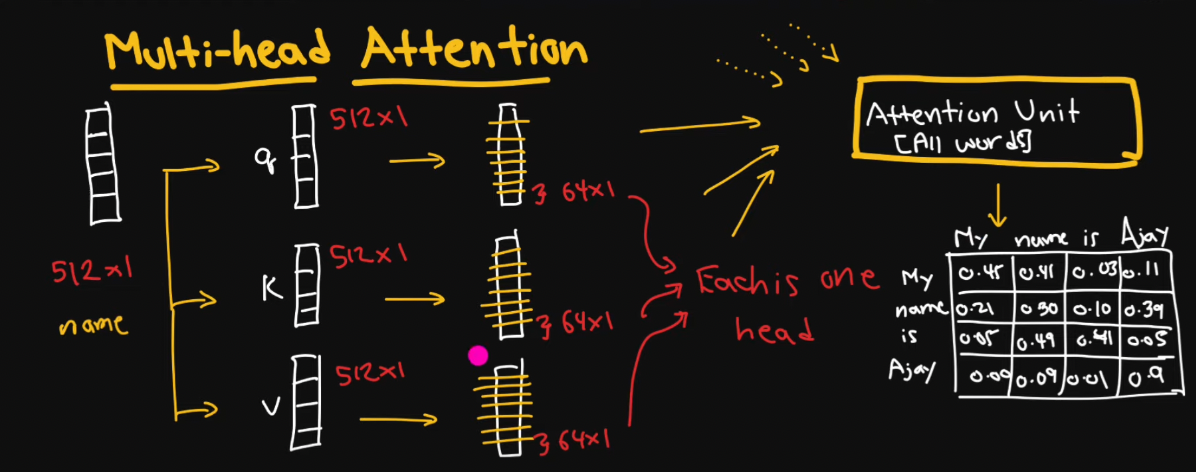

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [5]:
sequence_length = 4
batch_size = 1 #helps for parallel processing
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) ) 

In [6]:
x.size()

torch.Size([1, 4, 512])

In [7]:
x

tensor([[[-0.2246, -0.7578,  0.9042,  ..., -0.2106, -1.6825,  1.4472],
         [-0.5658, -0.8957, -0.2909,  ...,  0.5476,  0.9864, -0.6323],
         [ 1.6600,  0.9993, -0.2847,  ..., -0.7123, -2.3913,  1.1798],
         [ 0.4596, -0.7263, -0.0735,  ..., -0.8504, -1.3392, -1.8904]]])

In [8]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)
# Linear:  mathematical transformation that changes shape of input data
# output 3 * d_model: create 3 different things (query, key, and value) from each token


#nn.Linear(input_dim, 3 * d_model): 
##Creates a linear layer that projects each token from input_dim to 3 * d_model (1536). 
##This layer is used to generate the query, key, and value vectors (Q, K, V).

In [9]:
qkv = qkv_layer(x) 
#apply qkv_layer to x, transforms each token in input data from size input_dim to size 3 * d_model

In [10]:
qkv.shape 
#1 batch, 4 words, each word vector is 1536 in size

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

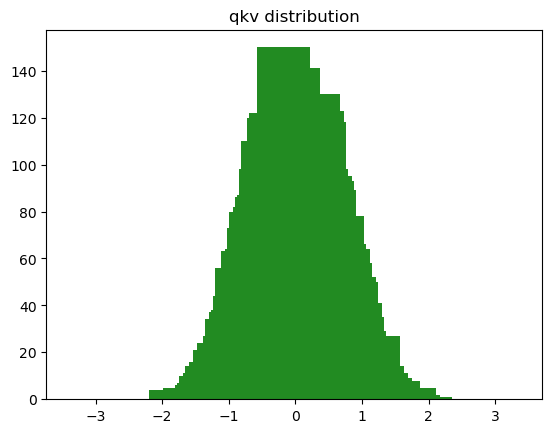

In [11]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3 ## Creates an array of values from -3 to 3, with a step of 0.03.

plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [12]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [13]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [14]:
qkv = qkv.permute(0, 2, 1, 3) #[batch_size, num_heads, sequence_length, 3*head_dim]
#Changes the order of dimensions to put the `num_heads` dimension before the `seq_length`
qkv.shape

torch.Size([1, 8, 4, 192])

In [15]:
q, k, v = qkv.chunk(3, dim=-1) #Splits the last dimension into 3 chunks along the last dimension.
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### SELF ATTENTION FOR MULTIPLE HEADS
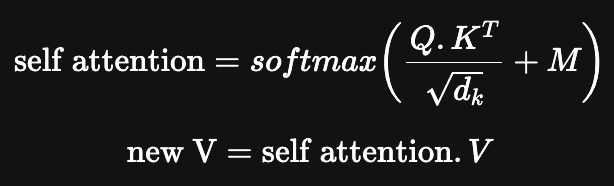

In [16]:
d_k = q.size()[-1]       #transpose the last 2 dimensions (seq length) and dim size
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) #represents the attention scores
scaled.shape

torch.Size([1, 8, 4, 4])

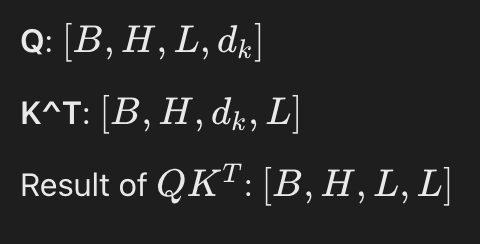

In [17]:
k.T.shape

/var/folders/4z/cwqvd_vs1p5c0315fd55cv040000gn/T/ipykernel_11754/3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [18]:
y = torch.randn(2,3)
torch.transpose(y, 0, 1)

tensor([[ 0.0394, -2.1514],
        [-0.2222, -0.3784],
        [-0.2313, -0.2604]])

In [19]:
torch.transpose(y, 1, 0)

tensor([[ 0.0394, -2.1514],
        [-0.2222, -0.3784],
        [-0.2313, -0.2604]])

In [20]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [21]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [22]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)  #leave upper unchanged
mask[0][1] #mask for input to a single head 

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [23]:
(scaled + mask)[0][0]

tensor([[ 0.1269,    -inf,    -inf,    -inf],
        [ 0.1478,  0.6965,    -inf,    -inf],
        [-0.0594,  0.4406, -0.2084,    -inf],
        [ 0.6135, -0.0151,  0.4661,  0.0771]], grad_fn=<SelectBackward0>)

In [24]:
scaled += mask   #exponent of -infinity will be 0

In [25]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [26]:
attention = F.softmax(scaled, dim=-1)

In [27]:
attention.shape

torch.Size([1, 8, 4, 4])

In [28]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3662, 0.6338, 0.0000, 0.0000],
        [0.2849, 0.4697, 0.2454, 0.0000],
        [0.3354, 0.1789, 0.2895, 0.1962]], grad_fn=<SelectBackward0>)

In [29]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Steps
*Initial linear projection:*
input tensor: [1, 4, 512]
             [batch_size, sequence_length, input_dim]
 1 sequence, each sequence has 4 tokens, and each token has 512 features.

after linear projection: [1, 4, 1536]
                        [batch_size, sequence_length, 3 * d_model].

Each token in the sequence has been projected from 512 dimensions to 1536 dimensions (3 * 512 for Q, K, and V).
                        
                        
1. Reshape qkv
   - original shape: [1, 4, 1536]
   - reshaped to: [1, 4, 8, 192]
   - Reshape: The shape [batch_size, sequence_length, 3 * d_model] is reshaped to [batch_size, sequence_length, num_heads, 3 * head_dim].
   - head_dim:  d_model // num_heads. (512 / 8) = 64
  
1 batch
4 tokens
8 heads
192 features per head (3 * 64, for Q, K, and V concatenated).

3. Permute dimensions
   -  change from [1, 4, 8, 192] to [1, 8, 4, 192]
   -  rearranges the tensor so that each head processes its portion of the sequence independently
  
5. Split into Q, K, V
   - Each of shape [1, 8, 4, 64], representing queries, keys, and values for each head.
  
6. Compute Scaled Dot-Product Attention:
   - q has a shape of [1, 8, 4, 64].
   - k.transpose(-2, -1) transposes the last two dimensions of k, = [1, 8, 64, 4].
   - torch.matmul(q, k.transpose(-2, -1)) matrix mul between q and k^T, resulting in a tensor of shape [1, 8, 4, 4].

In [30]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, 2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim = 1)
    values = torch.matmul(attention, v)
    return values, attention

In [31]:
values, attention = scaled_dot_product(q, k, v, mask=None)

In [32]:
attention.shape

torch.Size([1, 8, 4, 4])

In [34]:
 values.size()

torch.Size([1, 8, 4, 64])

In [35]:
values.shape

torch.Size([1, 8, 4, 64])

In [36]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [37]:
linear_layer = nn.Linear(d_model, d_model)

In [39]:
out = linear_layer(values)

In [40]:
out.shape

torch.Size([1, 4, 512])

In [41]:
import torch
import torch.nn as nn
import math

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size: {attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [ ]:
input_dim = 1024
d_model